In [1]:
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from scipy.stats import norm
import yfinance as yf
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
#Function that is forward looking - it looks for how many days it takes before you achieve X%
def days2gain(df):
    days=[0]*len(df['Close'])
    daysgain=[0]*len(df['Close'])
    
    for i in range(0,len(df['Close'])):
        for j in range(i,len(df['Close'])):
            if (df['Close'].iloc[j]-df['Close'].iloc[i])/df['Close'].iloc[i] >= ((df['High'].iloc[i] - df['Low'].iloc[i])/df['Low'].iloc[i])*2:
                cnt=j-i
                days[i]=cnt
                daysgain[i] = (df['Close'].iloc[j]-df['Close'].iloc[i])/df['Close'].iloc[i]
                break
            else:
                continue       
                
    
        
    df['days2']=days #THE DAYS TO ACHIEVE A PCT GAIN THAT IS GREATER THAN THE % DIFF OF (HIGH AND LOW)
    df['days2gain']=daysgain #THE ACTUAL % INCREASE WITH THE ASSOCIATED 

In [3]:

#function to tell me mhy rolling n day MAX & how far away/long ago i hit that max was
def daysfromhigh(df):
    roll_max=[]
    rolling_max=[0]*len(df)
    idx=[0]*len(df)
    diff=[0]*len(df)
    j=0
    k=[20,40,60]
    
    closelist=list(df['Close'])

    
    for u in k:
        col_name1=(str(u))
        col_name=("(" + str(u) + "," + "% From High"")")
        col_name2=("(" + str(u) + "," + "days from high"")")
        j=0
        firstfive=closelist[j:u]
        
        for i in range(u,len(df)):

            if i == u:

                max1=max(firstfive)

                max_index = firstfive.index(max1)
                rolling_max[i]=max1
                idx[i]=max_index
                diff[i] = (df['Close'].iloc[i] - rolling_max[i])/rolling_max[i]
                max1=0
                #max_index=0

            elif i > u:
                j+=1
                u+=1


                firstfive=closelist[j:u]         
                max1=max(firstfive)

                max_index = firstfive.index(max1)
                rolling_max[i]=max1
                idx[i]=u-(max_index+j)
                diff[i] = (df['Close'].iloc[i] - rolling_max[i])/rolling_max[i]
                max1=0
            
        
        df.loc[:,col_name1]=rolling_max

        df.loc[:,col_name2]=idx
       
        df.loc[:,col_name]=diff
        
        
        




    
        

In [4]:
gain=.05
comb=[]
ticker=[]
life_return=[]
tickss=[]
monthly_median=[]
openf=pd.read_csv('holding.csv',header=0,skiprows=0)
ticker=list(openf['Ticker'])


In [5]:
#Run tickers/stock through loop 
for tick in ticker:
    df=yf.download(tick,start='2010-01-01',end='2022-07-19')

    VIX=yf.download('^VIX',start='2010-01-01',end='2022-07-19')
    SPY=yf.download('^GSPC',start='2010-01-01',end='2022-07-19')
    
    df['Ticker']=tick
    df['Close']=df['Close'].round(2)
    df['PDIF']= (df['Close']-df['Close'].shift(1))/df['Close'].shift(1)
    df['WEEK_PDIF']= (df['Close']/df['Close'].shift(5))/df['Close'].shift(5)
    df['10MA'] = df['Close'].rolling(window=10).mean()
    df['Corr'] = df['Close'].rolling(window=10).corr(df['10MA'])
    df['FPDIF'] = (df['Close'].shift(-1)  - df['Close'])/df['Close']
    df['Open-Close'] = df['Open'] - df['Close'].shift(1)
    df['Open-Open'] = df['Open'] - df['Open'].shift(1)
    df['VIX'] = VIX['Close']
    df['SPY'] = SPY['Close']
    df['flag'] = np.where(df['FPDIF'] > 0, 1,-1)
    


    days2gain(df)
    #fivedays(df)
    #daysfromhigh(df)
    N=60
    df = df.iloc[N: , :]
   
    
    for i in range(0,len(df)):
        comb.append(df.iloc[i])
    
    df1=pd.DataFrame(data=comb,columns=df.columns)


    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


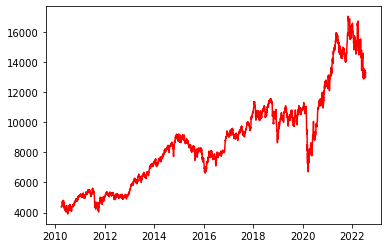

In [6]:
plt.plot(df1['Close'],color='red')
#plot close price over time frame

In [7]:
df1=df1.dropna()
#drop all na values

In [8]:
df1.corr()
#correlation matrix

,Open,High,Low,Close,Adj Close,Volume,PDIF,WEEK_PDIF,10MA,Corr,FPDIF,Open-Close,Open-Open,VIX,SPY,flag,days2,days2gain
Open,1.000000,0.999682,0.999636,0.999344,0.999344,0.408887,-0.019880,-0.917168,0.998314,0.024751,-0.024326,0.036460,0.018472,-0.033121,0.977855,-0.028029,-0.030312,-0.160870
High,0.999682,1.000000,0.999563,0.999672,0.999672,0.412250,-0.003621,-0.915792,0.998226,0.025452,-0.024799,0.042795,0.018786,-0.027166,0.978716,-0.028028,-0.030588,-0.154254
Low,0.999636,0.999563,1.000000,0.999742,0.999742,0.404442,-0.000466,-0.916779,0.997702,0.024988,-0.025039,0.044386,0.023269,-0.045089,0.977135,-0.027792,-0.030360,-0.173114
Close,0.999344,0.999672,0.999742,1.000000,1.000000,0.407925,0.012270,-0.915679,0.997726,0.025717,-0.026178,0.044922,0.020572,-0.037883,0.978053,-0.028287,-0.030445,-0.164966
Adj Close,0.999344,0.999672,0.999742,1.000000,1.000000,0.407925,0.012270,-0.915679,0.997726,0.025717,-0.026178,0.044922,0.020572,-0.037883,0.978053,-0.028287,-0.030445,-0.164966
Volume,0.408887,0.412250,0.404442,0.407925,0.407925,1.000000,0.005112,-0.364873,0.407576,0.041743,0.013082,0.115627,0.031057,0.394892,0.492180,-0.012785,-0.129508,0.219713
PDIF,-0.019880,-0.003621,-0.000466,0.012270,0.012270,0.005112,1.000000,0.056663,-0.020557,0.015890,-0.062490,0.485512,0.118601,-0.130100,0.005153,-0.006651,-0.002447,-0.110767
WEEK_PDIF,-0.917168,-0.915792,-0.916779,-0.915679,-0.915679,-0.364873,0.056663,1.000000,-0.922208,-0.037260,0.015972,-0.013414,0.044355,0.128574,-0.878414,0.017690,-0.015602,0.160418
10MA,0.998314,0.998226,0.997702,0.997726,0.997726,0.407576,-0.020557,-0.922208,1.000000,0.024671,-0.024335,0.026934,-0.013546,-0.018755,0.977405,-0.026542,-0.030912,-0.146319
Corr,0.024751,0.025452,0.024988,0.025717,0.025717,0.041743,0.015890,-0.037260,0.024671,1.000000,0.020402,-0.024672,0.004000,-0.021367,0.017085,0.016880,-0.032512,0.033412


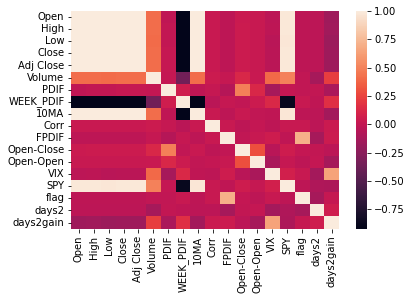

In [9]:
sns.heatmap(df1.corr());
#correlation matrix heatmap

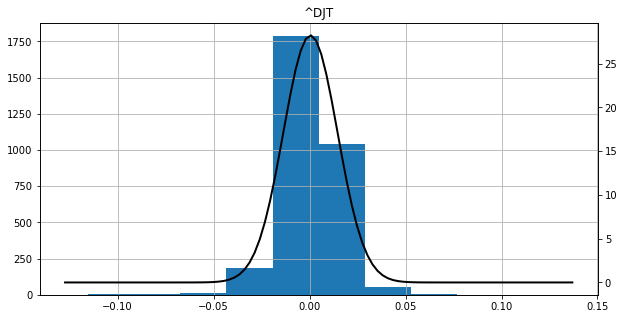

In [10]:
#develop normality plots/histograms of percentage returns
test=df1['Ticker'].unique()
for i in test:
    df_new=df1.loc[ df1["Ticker"] == i]
    fig, ax = plt.subplots(figsize = (10, 5))
    mu, std = norm.fit(df_new['PDIF']) 
    df_new['PDIF'].hist()

    ax2 = ax.twinx()

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
  
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    plt.title(i)
  
    plt.show()


    

In [11]:
#Get features to be X variables
X=df1[['Open','High','Low','Close','PDIF','Volume','VIX','SPY','WEEK_PDIF','10MA','Corr','Open-Close','Open-Open']].copy()

#Split training set
split = int(0.7*len(df1))

#Determine Y variable/Dependent Variable
y = np.where((df1['Close'].shift(-1) > df1['Close']) ,1,-1)

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [12]:
#Instantiate The Logistic Regression
model = LogisticRegression()
model = model.fit(X_train,y_train)

In [13]:
pd.DataFrame(zip(df1.columns, np.transpose(model.coef_)))

,0,1
0,Open,[4.775444413327779e-06]
1,High,[4.813080907352071e-06]
2,Low,[4.724626990863459e-06]
3,Close,[4.768030956482039e-06]
4,Adj Close,[-6.297097028526543e-13]
5,Volume,[-1.8283862221786788e-07]
6,Ticker,[1.718342911639034e-08]
7,PDIF,[1.2505241894134246e-06]
8,WEEK_PDIF,[1.311734297666458e-13]
9,10MA,[4.85314976442771e-06]


In [14]:
#Calculate Class Probabilities
probability = model.predict_proba(X_test)
print(probability)

[[0.46346493 0.53653507]
 [0.46348067 0.53651933]
 [0.46306156 0.53693844]
 ...
 [0.4915684  0.5084316 ]
 [0.47068962 0.52931038]
 [0.46980966 0.53019034]]


In [15]:
#Predict Class Labels
probability = model.predict_proba(X_test)
print(probability)

predicted = model.predict(X_test)

[[0.46346493 0.53653507]
 [0.46348067 0.53651933]
 [0.46306156 0.53693844]
 ...
 [0.4915684  0.5084316 ]
 [0.47068962 0.52931038]
 [0.46980966 0.53019034]]


In [16]:
print(metrics.confusion_matrix(y_test, predicted))

[[ 78 365]
 [ 90 396]]


In [17]:
#precision - % of correct positive predictions relative to total positive predictions
# recall - percentage of correct positive predictions relative to total actual positives
# F1 score - weighted harmonic mean of precision and recall - closer to 1, the better the model
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.46      0.18      0.26       443
           1       0.52      0.81      0.64       486

    accuracy                           0.51       929
   macro avg       0.49      0.50      0.45       929
weighted avg       0.49      0.51      0.45       929



In [18]:
print(model.score(X_test,y_test))

0.5102260495156081


In [19]:
#Cross Validation
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

[0.53225806 0.53548387 0.53225806 0.53225806 0.53225806 0.53398058
 0.53398058 0.53074434 0.48543689 0.53398058]
0.5282639106378537


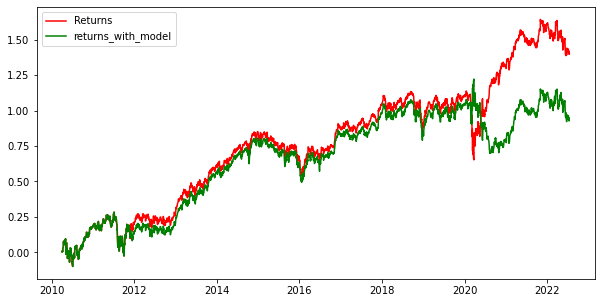

In [20]:
df1['Predicted_Signal'] = model.predict(X)
df1['returns'] = (df1['Close']-df1['Close'].shift(1))/df1['Close'].shift(1)
cumulative_index_returns = np.cumsum(df1['returns'])
df1['returns_with_model'] = df1['returns']* df1['Predicted_Signal'].shift(1)
cumulative_model_returns = np.cumsum(df1['returns_with_model'])

plt.figure(figsize=(10,5))
plt.plot(cumulative_index_returns, color='r',label = 'Returns')
plt.plot(cumulative_model_returns, color='g', label = 'returns_with_model')
plt.legend()
plt.show()

In [21]:
##Instantiate SVM 
cls = SVC().fit(X_train, y_train)

classifier_predictions = cls.predict(X_test)
print(accuracy_score(y_test,classifier_predictions)*100)

52.31431646932185


In [22]:
df1['Predicted_Signal_SVM'] = cls.predict(X)

In [23]:
df1['Returns'] = df1.Close.pct_change()
df1['Cum_Ret'] = df1['Returns'].cumsum()

In [24]:
df1['SVM_Returns'] = df1.Returns *df1.Predicted_Signal_SVM.shift(1)
df1['Cum_SVM_Returns'] = df1['SVM_Returns'].cumsum()

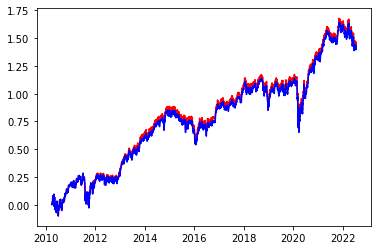

In [25]:
plt.plot(df1['Cum_SVM_Returns'],color='red')
plt.plot(df1['Cum_Ret'],color='blue')